In [1]:
import numpy as np
import pathlib
import tifffile as tf
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import *


In [2]:
import smart_wsi_scanner as sws

config = sws.ConfigManager()

# MIKE CONFIG
yaml_path = r"D:\2025QPSC\smartpath_configurations\config_PPM.yml"
# Load configuration using the config manager
ppm_settings = config.load_config_file(yaml_path)
loci_rsc_file = str(
    pathlib.Path(yaml_path).parent / "resources" / "resources_LOCI.yml"
)
loci_resources = config.load_config_file(loci_rsc_file)
ppm_settings.update(loci_resources)


In [3]:
# SANITY CHECK on LOADED CONFIG
ppm_settings['stage'], ppm_settings['modalities']['ppm']['rotation_stage']['device'], ppm_settings['ppm_pizstage_offset']

({'stage_id': 'LOCI_STAGE_PRIOR_001',
  'limits': {'x_um': {'low': -17000, 'high': 33000},
   'y_um': {'low': -12000, 'high': 13000},
   'z_um': {'low': -5601, 'high': -1600}}},
 'LOCI_STAGE_PI_001',
 -2098)

In [ ]:
if sws.hardware.is_mm_running():
    core,studio = sws.init_pycromanager()
    microscope_hardware = sws.PycromanagerHardware(core,studio,ppm_settings)
    

In [5]:
f"{(core.get_position("PIZStage"), microscope_hardware.get_psg_ticks())} assumes the default offset {microscope_hardware.settings['ppm_pizstage_offset']}"

'(88202, 90.3) assumes the default offset -2098'

In [10]:
t,d = microscope_hardware.snap_image()

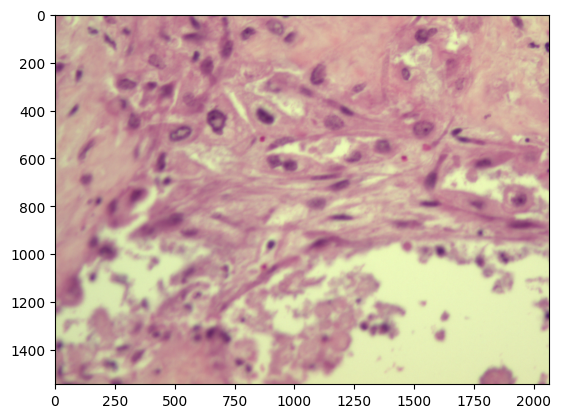

In [11]:
imshow(t)

In [22]:
#from pycromanager import Bridge
#bridge = Bridge()

In [ ]:
datastore = studio.data().create_ram_datastore()
datastore.put_image(mm_img)
studio.displays().create_display(datastore)

In [24]:
t.dtype

dtype('uint8')

In [25]:
from pycromanager import JavaObject
img = t.copy()
flat = img.tobytes()
jbytes = JavaObject('byte[]', flat)
mm_data_module = studio.data()
ImageClass = JavaObject('org.micromanager.data.Image')
metadata = mm_data_module.getMetadataBuilder().build()
mm_img = mm_data_module.createImage(
    jbytes,
    img.shape[1],  # width
    img.shape[0],  # height
    3,             # num components (RGB)
    1,             # bytes per pixel
    metadata
)
ds = mm_data_module.createRAMDatastore()
ds.putImage(mm_img)
studio.displays().createDisplay(ds)

Exception: java.lang.RuntimeException: Class not found on any classloaders
	at org.micromanager.pyjavaz.ZMQUtil.loadClass(ZMQUtil.java:463)
	at org.micromanager.pyjavaz.ZMQUtil.parseConstructors(ZMQUtil.java:350)
	at org.micromanager.pyjavaz.ZMQServer.parseAndExecuteCommand(ZMQServer.java:458)
	at org.micromanager.pyjavaz.ZMQServer.lambda$initialize$2(ZMQServer.java:121)
	at java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:511)
	at java.util.concurrent.FutureTask.run(FutureTask.java:266)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)


In [26]:
pixels = img.tobytes()   # <-- Python bytes; Java automatically wraps it
mm_data = studio.data()

In [31]:
md = mm_data.get_metadata_builder().build()

KeyboardInterrupt: 

In [ ]:
md

In [32]:
#md = mm_data.getMetadataBuilder().build()
mm_img = mm_data.create_image(
    pixels,             # Python bytes OK!
    img.shape[1],       # width
    img.shape[0],       # height
    3,                  # numComponents (RGB)
    1,                  # bytesPerPixel (uint8)
    #md
)

Exception: Incorrect arguments. 
Expected java.lang.Object, int, int, int, int, org.micromanager.data.Coords, org.micromanager.data.Metadata or java.lang.Object, int, int, int, int, org.micromanager.data.Coords, org.micromanager.data.Metadata 
Got <class 'bytes'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>

In [34]:
mm_img = mm_data.create_image(
    pixels,
    img.shape[1],   # width
    img.shape[0],   # height
    1,              # bytes per pixel
    3               # numComponents (RGB)
)


Exception: Incorrect arguments. 
Expected java.lang.Object, int, int, int, int, org.micromanager.data.Coords, org.micromanager.data.Metadata or java.lang.Object, int, int, int, int, org.micromanager.data.Coords, org.micromanager.data.Metadata 
Got <class 'bytes'>, <class 'int'>, <class 'int'>, <class 'int'>, <class 'int'>

In [ ]:
import numpy as np

img = np.random.randint(0,255,(512,512,3),dtype=np.uint8)
pixels = img.tobytes()

mm_data = studio.data()

# --- CRITICAL TRICK: use .copy() to avoid infinite hang ---
coords = mm_data.getCoordsBuilder().build().copy()
md = mm_data.getMetadataBuilder().build().copy()

mm_img = mm_data.createImage(
    pixels,
    img.shape[1],   # width
    img.shape[0],   # height
    1,              # bytes per pixel (uint8)
    3,              # numComponents (RGB)
    coords,
    md
)

ds = mm_data.createRAMDatastore()
ds.putImage(mm_img)

studio.displays().createDisplay(ds)


# FIND PI-Z Stage offset plot : 
# do not run after the PI stage is fixed, the offset would be fixed.

In [6]:
#core.set_position("PIZStage",20_000)
microscope_hardware.set_psg_ticks(0)
core.get_position("PIZStage"), microscope_hardware.get_psg_ticks() # (-51.49999999999999, -50.280199999999994)


(50230.5, 0.0018000000000029104)

In [47]:
core.get_exposure(), tags['PIZStage-Velocity']

(0.1, '100.0000')

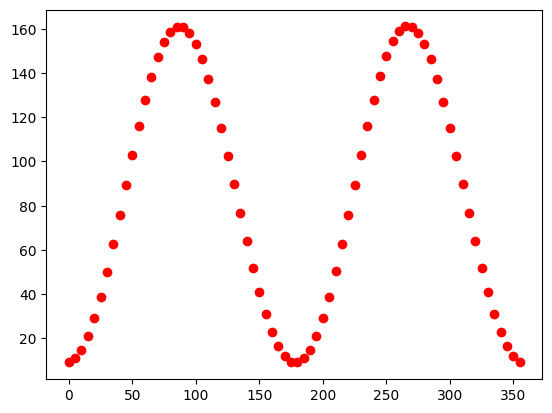

In [21]:
# takes two mins
arr = {}
for angle in range(0,360,5):
    core.set_position("PIZStage",angle*1000)
    core.wait_for_device("PIZStage")
    #microscope_hardware.set_psg_ticks(angle)
    
    img,tags = microscope_hardware.snap_image()
    arr.update({angle:(img,core.get_position("PIZStage"))})

for ix,k in enumerate(arr):
    plot(k,arr[k][0].mean(),'ro',label=str(k))
    #plot(arr[k][1],arr[k][0].mean(),'ro',label=str(k))

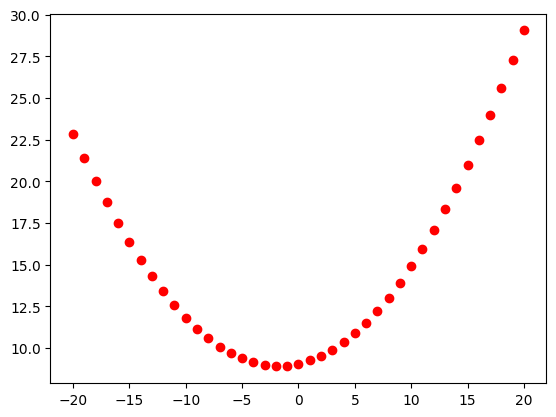

In [24]:
# takes 
arr = {}
for angle in range(-20,21,1):
    core.set_position("PIZStage",angle*1000)
    core.wait_for_device("PIZStage")
    #microscope_hardware.set_psg_ticks(angle)
    
    img,tags = microscope_hardware.snap_image()
    arr.update({angle:(img,core.get_position("PIZStage"))})

for ix,k in enumerate(arr):
    plot(k,arr[k][0].mean(),'ro',label=str(k))
    #plot(arr[k][1],arr[k][0].mean(),'ro',label=str(k))

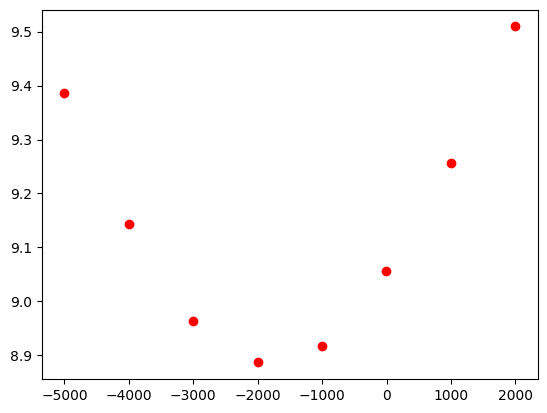

In [41]:
for k in range(-5,3,1):
    #plot(k,arr[k][0].mean(),'ro',label=str(k))
    plot(arr[k][1],arr[k][0].mean(),'ro',label=str(k))
    #plot(arr[k][1],arr[k][0].max(),'ro',label=str(k))
    

# load the offset

In [7]:
offset = -1800

In [8]:
core.get_position("PIZStage"), microscope_hardware.get_psg_ticks()

(50230.5, 0.0018000000000029104)

In [9]:
microscope_hardware.settings['ppm_pizstage_offset'] = offset

In [10]:
core.get_position("PIZStage"), microscope_hardware.get_psg_ticks()

(50230.5, 52.0305)

In [11]:
microscope_hardware.set_psg_ticks(0)

In [12]:
core.get_position("PIZStage"), microscope_hardware.get_psg_ticks()

(-1801.5, -0.0015)

# quick plot the curve for sanity check

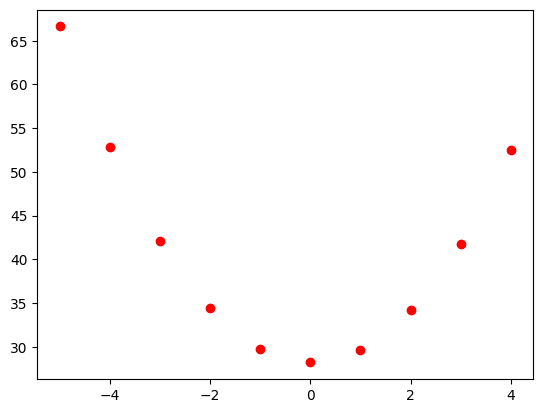

In [14]:
arr = {}
for angle in range(-5,6,1):
    #core.set_position("PIZStage",angle*1000)
    #core.wait_for_device("PIZStage")    
    microscope_hardware.set_psg_ticks(angle)
    img,tags = microscope_hardware.snap_image()
    pi_position = core.get_position("PIZStage")
    arr.update({angle:(img,pi_position)})
    plot(angle,arr[angle][0].mean(),'ro',label=f'{pi_position}')

# STEP2: align the PPA-optics

## checking both directions for background

In [ ]:
arr_align_for_bkg = {}

selected_angles = [-90,-7,-5,-3,0,3,5,7,90]
for j in selected_angles:
    microscope_hardware.set_psg_ticks(j)
    img,tags = microscope_hardware.snap_image()
    arr_align_for_bkg.update({j:(img,core.get_position("PIZStage"))})    
    

In [55]:
for j in [-90,-7,-5,-3,0,3,5,7,90]:
    print(j, f" {arr_align_for_bkg[j][1] :10.2f}, {arr_align_for_bkg[j][0].mean():6.2f}, {arr_align_for_bkg[j][0].max():6.2f}")

-90   -91801.50, 161.30, 255.00
-7    -8798.50,  11.03,  27.00
-5    -6801.50,   9.99,  25.00
-3    -4801.50,   9.34,  27.00
0    -1802.50,   8.88,  25.00
3     1198.50,   9.30,  27.00
5     3198.00,   9.96,  27.00
7     5197.50,  10.99,  25.00
90    88202.00, 161.17, 255.00


In [61]:


selected_angles = [-90,-7,-5,-3,0,3,5,7,90]

for j in selected_angles:
    img = arr_align_for_bkg[j][0]
    print(f"ideal exposure scaling for angle {j:3d} is {get_exposure_from_max(img):6.2f} ms")

ideal exposure scaling for angle -90 is   1.00 ms
ideal exposure scaling for angle  -7 is   9.44 ms
ideal exposure scaling for angle  -5 is  10.20 ms
ideal exposure scaling for angle  -3 is   9.44 ms
ideal exposure scaling for angle   0 is  10.20 ms
ideal exposure scaling for angle   3 is   9.44 ms
ideal exposure scaling for angle   5 is   9.44 ms
ideal exposure scaling for angle   7 is  10.20 ms
ideal exposure scaling for angle  90 is   1.00 ms


In [81]:
exp_scaling = [get_exposure_from_max(arr_align_for_bkg[img][0]) for img in arr_align_for_bkg] 
np.floor(min([ex for ex in exp_scaling if ex>1]))

np.float64(1.0)

In [82]:
current_exposure = float(core.get_property("JAICamera","Exposure"))
microscope_hardware.set_exposure(current_exposure*3.0)
current_exposure, float(core.get_property("JAICamera","Exposure"))

(2.7, 8.1)

In [77]:
float(core.get_property("JAICamera","Exposure"))

2.7

## plot 5 angles

In [43]:
import math

def get_exposure_from_max(arr):
    return 255/arr.max()

def smart_subplots(n, *, max_cols=None, width=4, height=3, sharex=False, sharey=False):
    """
    - Returns a 1-D list of axes (length n) so you can index with enumerate.
    - Hides any unused axes if rows*cols > n.
    """
    if n < 1:
        raise ValueError("n must be >= 1")

    # near-square layout
    cols = math.ceil(math.sqrt(n))
    if max_cols is not None:
        cols = min(cols, max_cols)
    rows = math.ceil(n / cols)

    fig, axs = plt.subplots(
        rows, cols,
        figsize=(cols * width, rows * height),
        sharex=sharex, sharey=sharey,
        squeeze=False  # always a 2D array for consistent flattening
    )

    flat = axs.ravel()

    # Hide extras, keep only first n axes in the return
    for k in range(n, rows * cols):
        flat[k].set_visible(False)

    fig.tight_layout()
    return fig, list(flat[:n])


def make_cxfloat_cxuint8(cx,contrast_stretch = 0.05):    
    if cx.dtype==np.float64:
        from skimage.util import img_as_ubyte

        #min_val = cx.min()
        #max_val = cx.max()
        
        min_val = np.percentile(cx, 0+contrast_stretch)
        max_val = np.percentile(cx, 100-contrast_stretch)
        normalized_float = np.clip((cx - min_val) / (max_val - min_val), 0.0, 1.0)
        uint8_rgb_array = img_as_ubyte(normalized_float)
        
        return(uint8_rgb_array)
    else:
        raise("input is not float64")
        return (cx)
    

## skip

ideal exposure scaling for angle  -7 is   1.00 ms instead of 10.00
ideal exposure scaling for angle  -5 is   1.00 ms instead of 10.00
ideal exposure scaling for angle   0 is   1.00 ms instead of 10.00
ideal exposure scaling for angle   0 is   1.00 ms instead of 10.00
ideal exposure scaling for angle   5 is   1.00 ms instead of 10.00
ideal exposure scaling for angle   7 is   1.00 ms instead of 10.00


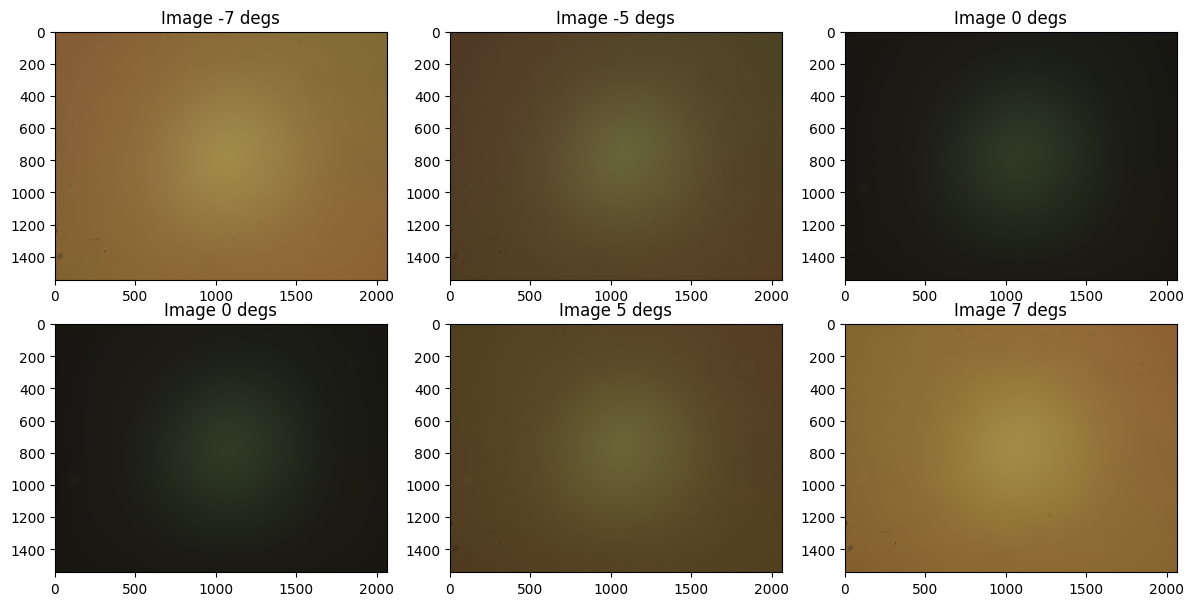

In [17]:
arr_align_for_bkg = {}
selected_angles = [-7,-5,0,0,5,7]
naxis = len(selected_angles)
fig, axes = smart_subplots(naxis, max_cols=4, width=4, height=3)

for ix,j in enumerate(selected_angles):
    microscope_hardware.set_psg_ticks(j)
    img,tags = microscope_hardware.snap_image()
    arr_align_for_bkg.update({j:(img,
                                 core.get_position("PIZStage"),
                                 float(core.get_property("JAICamera","Exposure"))
                                 )})    
    ax = axes[ix]
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Image {j} degs")

for j in selected_angles:
    img = arr_align_for_bkg[j][0]
    expo = arr_align_for_bkg[j][2]
    print(f"ideal exposure scaling for angle {j:3d} is {get_exposure_from_max(img):6.2f} ms instead of {expo:.2f}")

In [18]:
for j in selected_angles:
    img = arr_align_for_bkg[j][0]
    print(f"ideal exposure scaling for angle {j:3d} is {get_exposure_from_max(img):6.2f} ms {img.max()}")

ideal exposure scaling for angle  -7 is   1.00 ms 255
ideal exposure scaling for angle  -5 is   1.00 ms 255
ideal exposure scaling for angle   0 is   1.00 ms 255
ideal exposure scaling for angle   0 is   1.00 ms 255
ideal exposure scaling for angle   5 is   1.00 ms 255
ideal exposure scaling for angle   7 is   1.00 ms 255


## plot for bkg

In [28]:
len(arr_align_for_bkg)

5

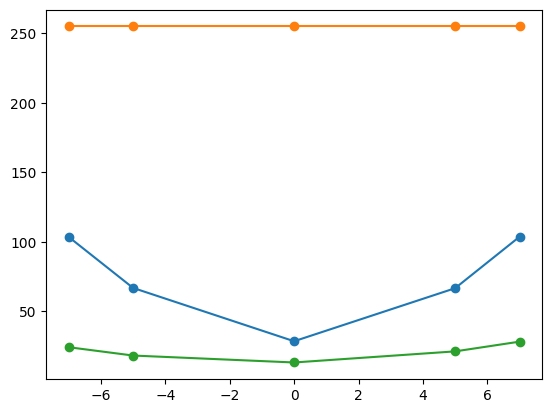

In [35]:
plot([k for k in arr_align_for_bkg],
     [(arr_align_for_bkg[k][0].mean(),
       arr_align_for_bkg[k][0].max(),
       arr_align_for_bkg[k][0].min()
       ) for k in arr_align_for_bkg],
     marker ='o',
     #'or'
     )

ideal exposure scaling for angle  -7 is   1.26 ms instead of 7.0
ideal exposure scaling for angle  -5 is   1.54 ms instead of 7.0
ideal exposure scaling for angle   0 is   2.02 ms instead of 7.0
ideal exposure scaling for angle   0 is   2.02 ms instead of 7.0
ideal exposure scaling for angle   5 is   1.55 ms instead of 7.0
ideal exposure scaling for angle   7 is   1.26 ms instead of 7.0


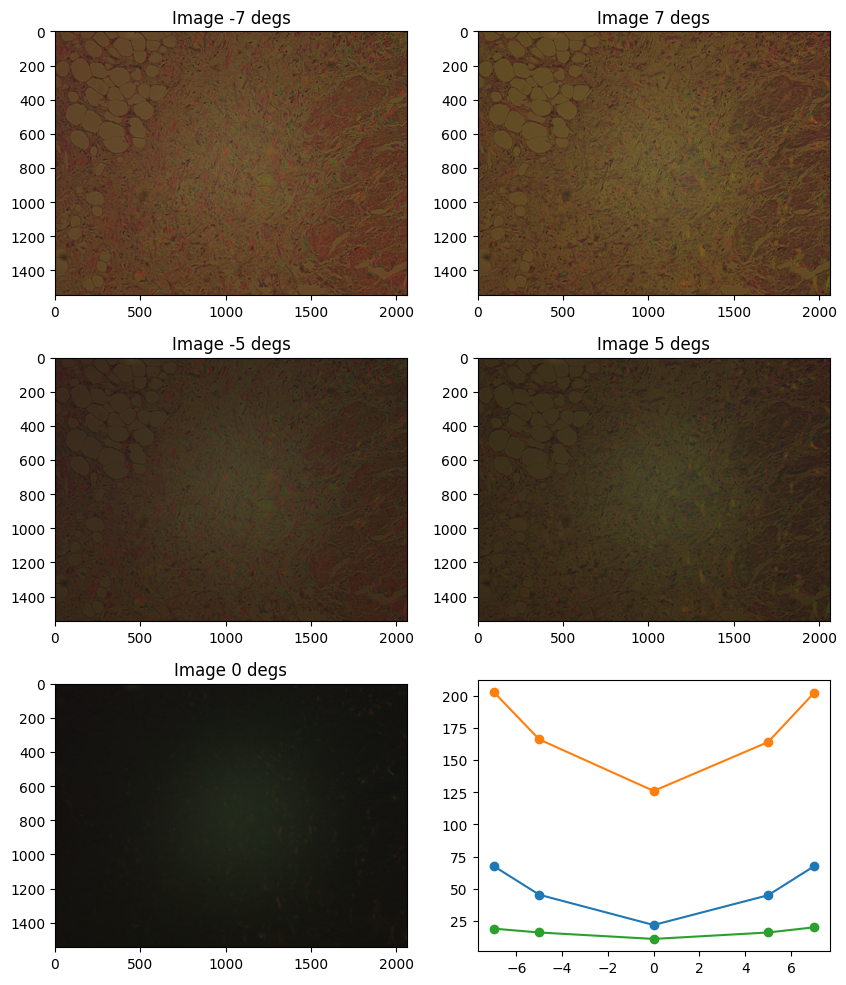

In [39]:
arr_align_for_bkg = {}
selected_angles = [-7,-5,0,0,5,7]
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
axes = axs.ravel()  # Flatten to easily index
positions = {
    -7: 0,
    -5: 2,
     0: 4,  # middle left (mean/max will go on the right)
     5: 3,
     7: 1
}

for ix,j in enumerate(selected_angles):
    microscope_hardware.set_psg_ticks(j)
    img,tags = microscope_hardware.snap_image()
    arr_align_for_bkg.update({j:(img,
                                 core.get_position("PIZStage"),
                                 float(core.get_property("JAICamera","Exposure"))
                                 )})    
    ax = axes[positions[j]]
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Image {j} degs")    

axes[5].plot([k for k in arr_align_for_bkg],
     [(arr_align_for_bkg[k][0].mean(),
       arr_align_for_bkg[k][0].max(),
       arr_align_for_bkg[k][0].min()
       ) for k in arr_align_for_bkg],
     marker ='o',)

for j in selected_angles:
    img = arr_align_for_bkg[j][0]
    expo = arr_align_for_bkg[j][2]
    print(f"ideal exposure scaling for angle {j:3d} is {get_exposure_from_max(img):6.2f} ms instead of {expo}")


# get background images 

ideal exposure scaling for angle  -7 is   1.30 ms instead of 7.0
ideal exposure scaling for angle  -5 is   1.50 ms instead of 7.0
ideal exposure scaling for angle   0 is   2.07 ms instead of 7.0
ideal exposure scaling for angle   0 is   2.07 ms instead of 7.0
ideal exposure scaling for angle   5 is   1.60 ms instead of 7.0
ideal exposure scaling for angle   7 is   1.31 ms instead of 7.0


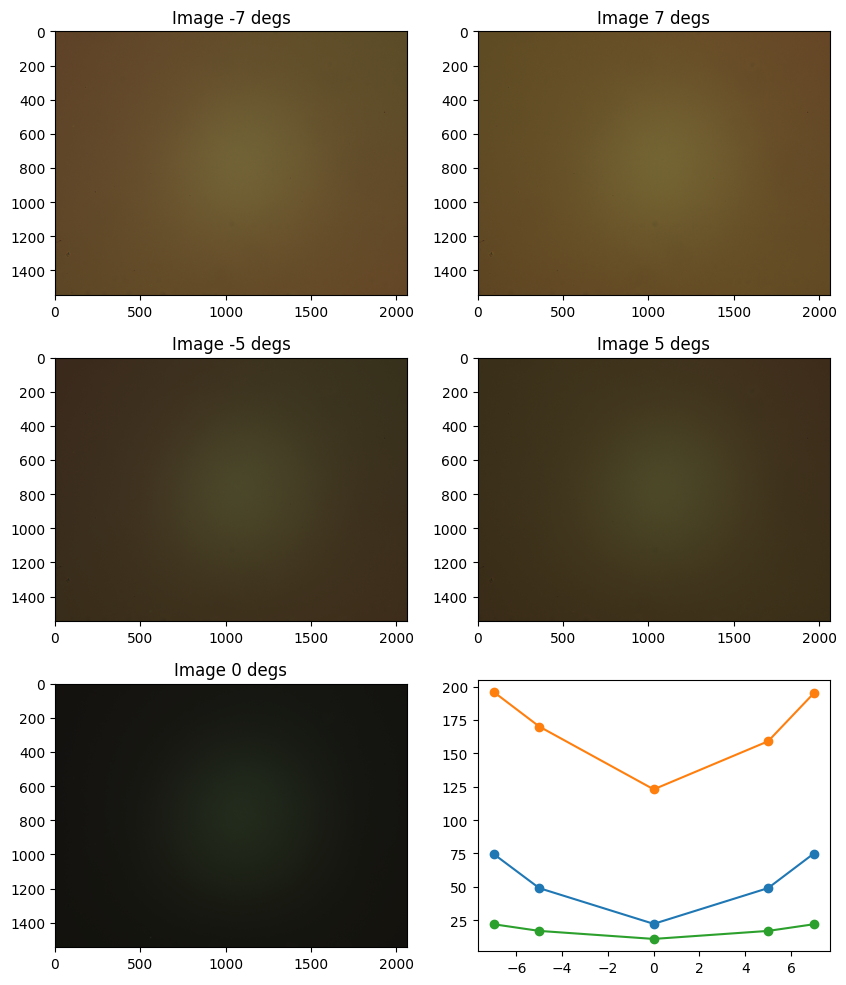

In [41]:
bkg = {}
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
axes = axs.ravel()  # Flatten to easily index

for ix,j in enumerate(selected_angles):
    microscope_hardware.set_psg_ticks(j)
    img,tags = microscope_hardware.snap_image()
    bkg.update({j:(img,
                                 core.get_position("PIZStage"),
                                 float(core.get_property("JAICamera","Exposure"))
                                 )})    
    ax = axes[positions[j]]
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Image {j} degs")    

axes[5].plot([k for k in bkg],
     [(bkg[k][0].mean(),
       bkg[k][0].max(),
       bkg[k][0].min()
       ) for k in bkg],
     marker ='o',)

for j in selected_angles:
    img = bkg[j][0]
    expo = bkg[j][2]
    print(f"ideal exposure scaling for angle {j:3d} is {get_exposure_from_max(img):6.2f} ms instead of {expo}")


## corrected

ideal exposure scaling for angle  -7 is   1.00 ms instead of 7.0
ideal exposure scaling for angle  -5 is   1.09 ms instead of 7.0
ideal exposure scaling for angle   0 is   1.73 ms instead of 7.0
ideal exposure scaling for angle   0 is   1.73 ms instead of 7.0
ideal exposure scaling for angle   5 is   1.38 ms instead of 7.0
ideal exposure scaling for angle   7 is   1.09 ms instead of 7.0


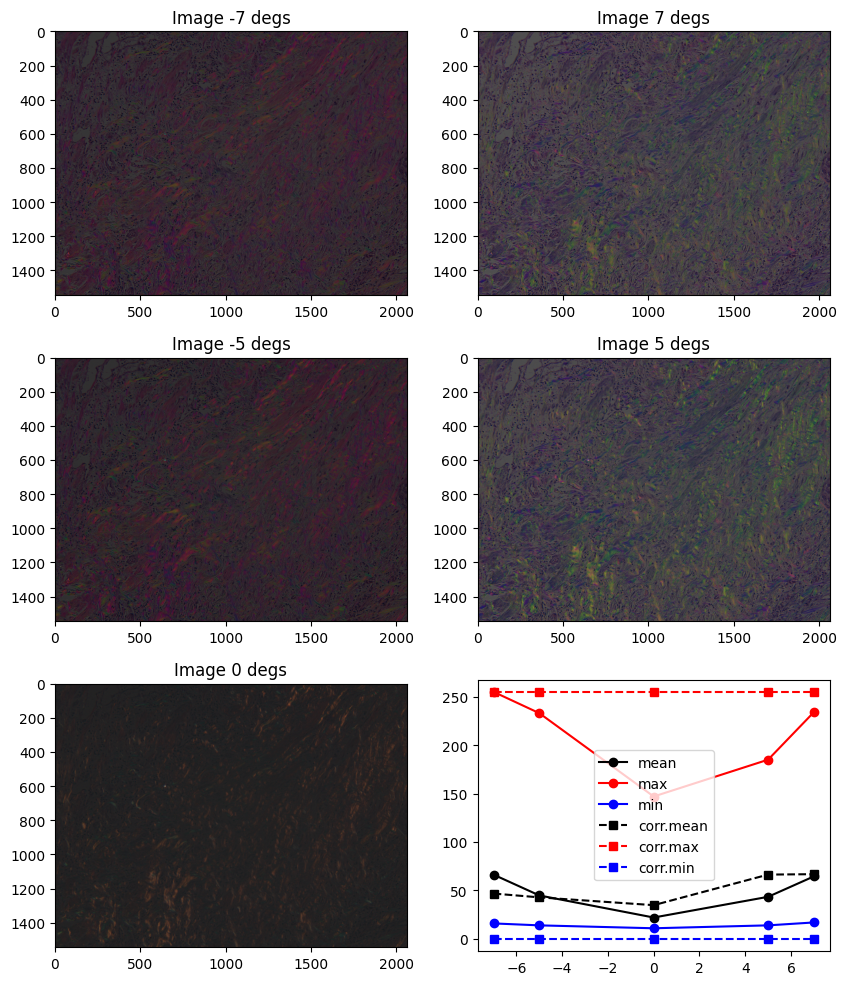

In [68]:
data = {}
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
axes = axs.ravel()  # Flatten to easily index

for ix,j in enumerate(selected_angles):
    microscope_hardware.set_psg_ticks(j)
    img,tags = microscope_hardware.snap_image()
    corr_img = make_cxfloat_cxuint8(img/bkg[j][0],contrast_stretch=0)
    data.update({j:(img,
                                 core.get_position("PIZStage"),
                                 float(core.get_property("JAICamera","Exposure")),
                                 corr_img
                                 )})    
    ax = axes[positions[j]]
    ax.imshow(corr_img)
    ax.set_title(f"Image {j} degs")    

#with plt.rc_context({'axes.prop_cycle': cycler(color=['k', 'r', 'b'])}):
axes[5].set_prop_cycle(cycler(color=['k', 'r', 'b']))
axes[5].plot([k for k in data],
    [(data[k][0].mean(),
      data[k][0].max(),
      data[k][0].min()
      ) for k in data],
    marker ='o',
    label =["mean","max","min"])
  
axes[5].plot([k for k in data],
    [(data[k][3].mean(),
      data[k][3].max(),
      data[k][3].min()
      ) for k in data],
    marker ='s',linestyle ='--',
    label =["corr.mean","corr.max","corr.min"])
legend()
  
for j in selected_angles:
    img = data[j][0]
    expo = data[j][2]
    print(f"ideal exposure scaling for angle {j:3d} is {get_exposure_from_max(img):6.2f} ms instead of {expo}")


In [90]:
from scipy import stats

In [96]:
    print(stats.describe(img1.ravel()))
    print(stats.describe(img2.ravel()))


DescribeResult(nobs=9560448, minmax=(np.uint8(0), np.uint8(255)), mean=np.float64(66.82518402903295), variance=np.float64(213.5761191653715), skewness=np.float64(-0.4544580858363807), kurtosis=np.float64(0.9367872707663345))
DescribeResult(nobs=9560448, minmax=(np.uint8(0), np.uint8(255)), mean=np.float64(46.82191284341487), variance=np.float64(135.45885428304874), skewness=np.float64(-0.13283620525474396), kurtosis=np.float64(0.7322588051416128))


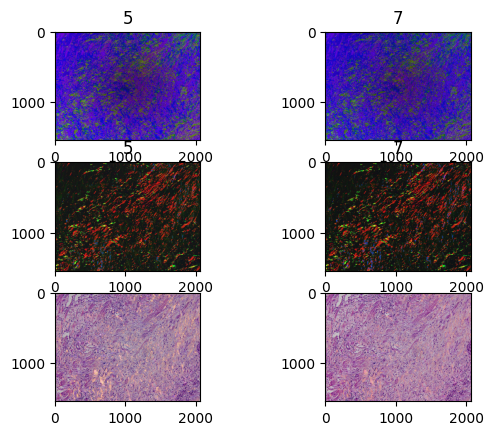

In [114]:
fig,ax = subplots(3,2)
ncols = 2

axs = ax.ravel()
used_angles = set(abs(np.array(selected_angles)))
used_angles.discard(0)
temp= []
for ix,j in enumerate(used_angles):
    
    img1 = data[j][0]
    img2 = data[-j][0]
    
    corrx = make_cxfloat_cxuint8( (img1-img2)*1.0/(img1+img2+0.01) ,1)
    axs[ix].set_title(j)
    axs[ix].imshow(corrx)
    #print(j)
    #print(stats.describe(img1.ravel()))
    #print(stats.describe(img2.ravel()))
    #print(stats.describe(corrx.ravel()))
    if j==7:
        temp = corrx
    
    img1 = data[j][3]
    img2 = data[-j][3]
    corrx = make_cxfloat_cxuint8( (img1-img2)*1.0/(img1+img2+0.01),2)
    axs[ix+ncols].set_title(j)
    axs[ix+ncols].imshow(corrx)

    corr_sum = make_cxfloat_cxuint8(img1+img2*1.0 ,1)
    axs[ix+2*ncols].imshow(corr_sum)
    
    

In [102]:
temp.shape

(1544, 2064, 3)

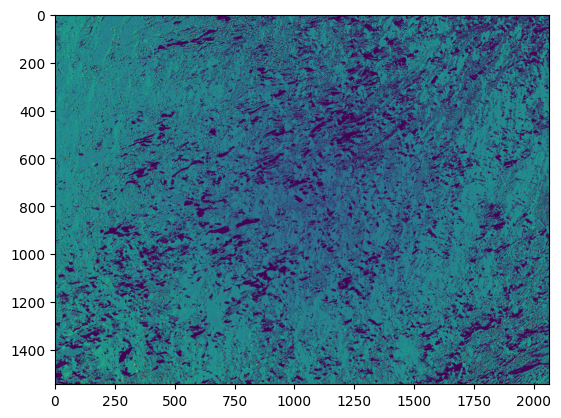

In [105]:
imshow(temp[:,:,2])